In [1]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

/home/gordonbchen/code/ml_explore/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [2]:
# weight tying token embeddings and lm head.
sd_hf["lm_head.weight"].data_ptr() == sd_hf["transformer.wte.weight"].data_ptr()

True

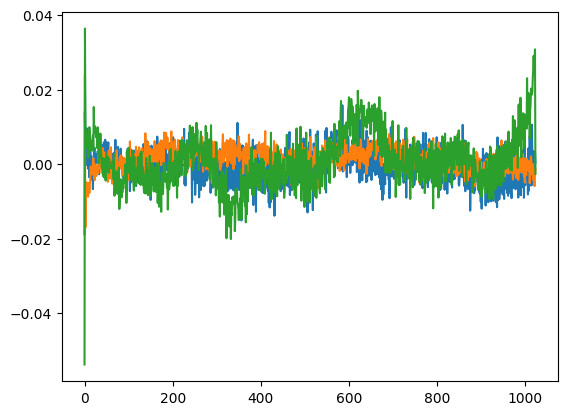

In [3]:
import matplotlib.pyplot as plt

plt.plot(sd_hf["transformer.wpe.weight"][:, 0])
plt.plot(sd_hf["transformer.wpe.weight"][:, 100])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])

In [4]:
from transformers import pipeline, set_seed

set_seed(42)
generator = pipeline("text-generation", model="gpt2")
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5, temperature=1.0)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so I can write things that are easy to understand with help of my programming language."\n\nHowever, this'},
 {'generated_text': "Hello, I'm a language model, because no matter how much I write code, I never actually understand it for a second. My only way of"},
 {'generated_text': "Hello, I'm a language model, so I'm willing to explain it here.\n\nFirst, let's see which syntax we're going to"},
 {'generated_text': 'Hello, I\'m a language model, not a design model."\n\nThe idea\n\nThe next stage is about finding a way to combine all'},
 {'generated_text': "Hello, I'm a language model, using the language models of the other software, and so on, so please think and tell me if your language"}]

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken

@torch.no_grad()
def generate(model: nn.Module, block_size: int, prompt: str, n_sequences: int, max_length: int) -> list[str]:
    model.eval()

    tok = tiktoken.get_encoding("gpt2")
    tokens = torch.tensor(tok.encode(prompt), dtype=torch.long, device="cuda")
    tokens = tokens.unsqueeze(0).repeat(n_sequences, 1)

    while tokens.shape[-1] < max_length:
        logits = model(tokens[:, -block_size :]).logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_inds = probs.topk(50, dim=-1)
        inds = torch.multinomial(topk_probs, num_samples=1)
        new_inds = topk_inds.gather(1, inds)
        tokens = torch.cat((tokens, new_inds), dim=-1)

    completions = tok.decode_batch(tokens.tolist())
    return completions

model_hf.to("cuda")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for c in generate(model_hf, block_size=1024, prompt="Hello, I'm a language model,", n_sequences=4, max_length=64):
    print("<", c)

< Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not a hard question, I decided to do it before I knew what I was doing. The goal is this: I wanted to see if my results would be better than the
< Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that is difficult to understand. I find myself more confused about how to understand than I normally am. And because of that, I try to work in a very informal way,
< Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not sure if that's true.

But let's go back to your question about learning a language through formal procedures and procedures.

My mother taught me to use
< Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages and, you k

In [6]:
import requests
from pathlib import Path

def get_shakespeare_data(path="data/tiny_shakespeare.txt"):
    path = Path(path)
    if not path.exists():
        path.parent.mkdir(exist_ok=True)
        text = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt").text
        with open(path, "w") as f:
            f.write(text)
        return text

    with open(path, "r") as f:
        text = f.read()
    return text

text = get_shakespeare_data()
print(text[:400])

tok = tiktoken.get_encoding("gpt2")
tokens = tok.encode(text)
print(tokens[:32])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 
[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13, 198, 198, 5962, 22307, 25, 198, 1639, 389]


In [7]:
buf = torch.tensor(tokens[:24+1])
x = buf[:-1].view(4, 6)
print(x)

y = buf[1:].view(4, 6)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])
